# **Working with Images & Logistic Regression in PyTorch**

This notebook contains the following topics:

* Working with images in PyTorch (using the MNIST dataset)
* Splitting a dataset into training, validation, and test sets
* Creating PyTorch models with custom logic by extending the nn.Module class
* Interpreting model outputs as probabilities using Softmax and picking predicted labels
* Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification problems
* Setting up a training loop that also evaluates the model using the validation set
* Testing the model manually on randomly picked examples
* Saving and loading model checkpoints to avoid retraining from scratch

In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


When this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch Dataset. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [3]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F9BA18B50B8>, 5)

Display the first image from our dataset

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


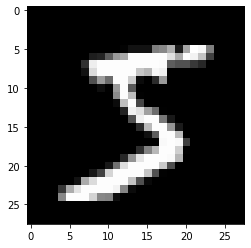

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


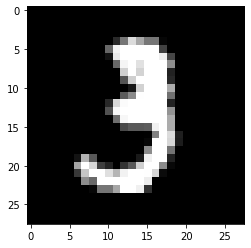

In [8]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

In [10]:
# We'll use the ToTensor transform to convert images into PyTorch tensors
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True,transform=transforms.ToTensor())

In [11]:
# Let check the shape of tensor
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [12]:
# These are tensors
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


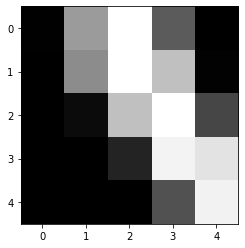

In [13]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

# **Training and Validation Datasets**

In [14]:
# split dataset into training and validation parts
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [15]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

# **Model**

In [16]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [17]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0232, -0.0110,  0.0076,  ..., -0.0183,  0.0191, -0.0321],
        [-0.0293,  0.0331,  0.0109,  ...,  0.0060,  0.0207,  0.0084],
        [-0.0271,  0.0106,  0.0192,  ...,  0.0098, -0.0021, -0.0068],
        ...,
        [-0.0034, -0.0321, -0.0301,  ..., -0.0030, -0.0098,  0.0263],
        [ 0.0206, -0.0167, -0.0058,  ...,  0.0116,  0.0146, -0.0305],
        [ 0.0134,  0.0092, -0.0052,  ..., -0.0008, -0.0059,  0.0350]],
       requires_grad=True)

In [18]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0149,  0.0179, -0.0144,  0.0125,  0.0267, -0.0047,  0.0007,  0.0169,
        -0.0324, -0.0222], requires_grad=True)

In [19]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([2, 5, 9, 3, 2, 3, 7, 8, 2, 8, 4, 9, 7, 6, 5, 7, 9, 6, 2, 1, 9, 7, 4, 0,
        8, 6, 7, 6, 8, 8, 3, 3, 1, 8, 5, 4, 1, 6, 7, 7, 8, 7, 4, 4, 5, 4, 7, 0,
        4, 8, 7, 7, 3, 3, 6, 6, 3, 2, 5, 3, 3, 1, 4, 8, 9, 7, 1, 2, 9, 5, 6, 0,
        0, 7, 9, 2, 3, 5, 1, 4, 5, 7, 4, 0, 9, 3, 8, 5, 9, 3, 2, 6, 1, 0, 5, 0,
        7, 5, 5, 1, 6, 6, 3, 6, 2, 7, 9, 8, 2, 0, 5, 1, 1, 7, 8, 1, 1, 8, 3, 8,
        3, 3, 9, 2, 8, 3, 3, 6])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [20]:
images.shape

torch.Size([128, 1, 28, 28])

In [21]:
images.reshape(128, 784).shape

torch.Size([128, 784])

Classes can also build upon or extend the functionality of existing classes. Let's extend the nn.Module class from PyTorch to define a custom model.

In [22]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

* Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

* xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

* Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [23]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [24]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0317, -0.0347, -0.0218,  ..., -0.0173,  0.0106,  0.0334],
         [ 0.0007,  0.0341,  0.0328,  ...,  0.0171,  0.0228,  0.0142],
         [-0.0146,  0.0223, -0.0025,  ..., -0.0179,  0.0081, -0.0218],
         ...,
         [-0.0138, -0.0098,  0.0203,  ..., -0.0069, -0.0293,  0.0009],
         [-0.0215,  0.0333, -0.0190,  ..., -0.0294,  0.0219, -0.0092],
         [-0.0086,  0.0249,  0.0215,  ...,  0.0072, -0.0248, -0.0343]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0208, -0.0086,  0.0303, -0.0044,  0.0149,  0.0214,  0.0074, -0.0078,
         -0.0119, -0.0096], requires_grad=True)]

In [25]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0680,  0.0010, -0.0174,  0.2042,  0.0447, -0.0384,  0.1156, -0.0147,
          0.0966,  0.1747],
        [ 0.4832,  0.3567,  0.2967,  0.4673, -0.0919, -0.0341,  0.3976,  0.1800,
          0.3019, -0.0966]])


In [26]:
import torch.nn.functional as F

The softmax function is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be applied.

In [27]:
outputs[:2]

tensor([[ 0.0680,  0.0010, -0.0174,  0.2042,  0.0447, -0.0384,  0.1156, -0.0147,
          0.0966,  0.1747],
        [ 0.4832,  0.3567,  0.2967,  0.4673, -0.0919, -0.0341,  0.3976,  0.1800,
          0.3019, -0.0966]], grad_fn=<SliceBackward>)

In [28]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1001, 0.0936, 0.0919, 0.1147, 0.0978, 0.0900, 0.1050, 0.0922, 0.1030,
         0.1114],
        [0.1265, 0.1115, 0.1050, 0.1245, 0.0712, 0.0754, 0.1161, 0.0934, 0.1055,
         0.0708]])
Sum:  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [29]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([3, 0, 8, 3, 3, 0, 8, 6, 8, 0, 0, 6, 1, 8, 7, 2, 9, 3, 9, 0, 0, 8, 0, 8,
        0, 8, 4, 8, 0, 1, 9, 6, 3, 3, 3, 0, 8, 8, 0, 3, 3, 6, 8, 6, 0, 7, 0, 0,
        3, 0, 8, 3, 0, 1, 8, 0, 8, 3, 8, 0, 3, 0, 3, 8, 8, 7, 9, 1, 1, 8, 3, 3,
        3, 6, 0, 0, 3, 8, 1, 8, 3, 3, 1, 8, 6, 0, 8, 9, 3, 8, 0, 1, 8, 1, 2, 8,
        3, 7, 0, 0, 0, 3, 0, 3, 0, 1, 1, 6, 7, 8, 6, 7, 0, 8, 0, 8, 0, 8, 8, 3,
        1, 4, 3, 1, 0, 1, 3, 3])
tensor([0.1147, 0.1265, 0.1261, 0.1353, 0.1434, 0.1357, 0.1253, 0.1246, 0.1514,
        0.1315, 0.1406, 0.1450, 0.1305, 0.1348, 0.1352, 0.1405, 0.1177, 0.1261,
        0.1118, 0.1227, 0.1538, 0.1464, 0.1374, 0.1226, 0.1560, 0.1185, 0.1145,
        0.1256, 0.1404, 0.1278, 0.1224, 0.1217, 0.1259, 0.1201, 0.1278, 0.1398,
        0.1290, 0.1425, 0.1438, 0.1648, 0.1421, 0.1458, 0.1324, 0.1309, 0.1408,
        0.1275, 0.1325, 0.1379, 0.1418, 0.1438, 0.1353, 0.1357, 0.1237, 0.1274,
        0.1357, 0.1337, 0.1281, 0.1403, 0.1160, 0.1471, 0.1434, 0.1225, 0.1453,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [30]:
labels

tensor([5, 6, 5, 8, 0, 6, 1, 3, 9, 2, 6, 9, 8, 6, 2, 0, 1, 3, 1, 7, 6, 6, 8, 1,
        2, 2, 1, 1, 2, 9, 1, 9, 1, 7, 6, 4, 6, 2, 2, 6, 5, 5, 6, 3, 6, 5, 4, 2,
        3, 3, 3, 8, 5, 2, 9, 7, 1, 8, 1, 4, 0, 6, 8, 5, 6, 1, 5, 3, 8, 1, 5, 8,
        4, 4, 8, 4, 9, 6, 3, 5, 3, 7, 0, 0, 7, 6, 0, 3, 3, 1, 2, 5, 4, 3, 8, 0,
        1, 7, 7, 2, 9, 5, 8, 0, 6, 8, 3, 9, 4, 3, 9, 4, 4, 4, 3, 4, 3, 5, 9, 5,
        8, 1, 3, 3, 7, 1, 9, 1])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

# **Evaluation Metric and Loss Function**

In [31]:
outputs[:2]

tensor([[ 0.0680,  0.0010, -0.0174,  0.2042,  0.0447, -0.0384,  0.1156, -0.0147,
          0.0966,  0.1747],
        [ 0.4832,  0.3567,  0.2967,  0.4673, -0.0919, -0.0341,  0.3976,  0.1800,
          0.3019, -0.0966]], grad_fn=<SliceBackward>)

In [32]:
torch.sum(preds == labels)

tensor(7)

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
accuracy(outputs, labels)

tensor(0.0547)

In [35]:
probs

tensor([[0.1001, 0.0936, 0.0919,  ..., 0.0922, 0.1030, 0.1114],
        [0.1265, 0.1115, 0.1050,  ..., 0.0934, 0.1055, 0.0708],
        [0.1071, 0.0900, 0.0867,  ..., 0.1120, 0.1261, 0.0752],
        ...,
        [0.1125, 0.1192, 0.0793,  ..., 0.1051, 0.1077, 0.0791],
        [0.0999, 0.1086, 0.1045,  ..., 0.1007, 0.1219, 0.0701],
        [0.1007, 0.1051, 0.1089,  ..., 0.0839, 0.1067, 0.1129]],
       grad_fn=<SoftmaxBackward>)

In [36]:
outputs

tensor([[ 0.0680,  0.0010, -0.0174,  ..., -0.0147,  0.0966,  0.1747],
        [ 0.4832,  0.3567,  0.2967,  ...,  0.1800,  0.3019, -0.0966],
        [ 0.1450, -0.0290, -0.0664,  ...,  0.1895,  0.3080, -0.2088],
        ...,
        [ 0.2222,  0.2803, -0.1279,  ...,  0.1537,  0.1790, -0.1304],
        [ 0.1005,  0.1843,  0.1461,  ...,  0.1089,  0.2999, -0.2536],
        [ 0.0105,  0.0529,  0.0883,  ..., -0.1719,  0.0681,  0.1247]],
       grad_fn=<AddmmBackward>)

In [37]:
loss_fn = F.cross_entropy


In [39]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3291, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

# **Training the Model**


Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection


In [40]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [41]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefine the MnistModel class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [42]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.



In [43]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.10828718543052673, 'val_loss': 2.3576433658599854}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [45]:
history1 = fit(5, 0.002, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0524, val_acc: 0.8144
Epoch [1], val_loss: 0.9405, val_acc: 0.8238
Epoch [2], val_loss: 0.8605, val_acc: 0.8325
Epoch [3], val_loss: 0.8005, val_acc: 0.8400
Epoch [4], val_loss: 0.7536, val_acc: 0.8454


In [46]:
history2 = fit(5, 0.002, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7160, val_acc: 0.8490
Epoch [1], val_loss: 0.6850, val_acc: 0.8528
Epoch [2], val_loss: 0.6590, val_acc: 0.8559
Epoch [3], val_loss: 0.6366, val_acc: 0.8592
Epoch [4], val_loss: 0.6174, val_acc: 0.8611


In [47]:
history3 = fit(5, 0.002, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6006, val_acc: 0.8622
Epoch [1], val_loss: 0.5856, val_acc: 0.8645
Epoch [2], val_loss: 0.5724, val_acc: 0.8659
Epoch [3], val_loss: 0.5606, val_acc: 0.8674
Epoch [4], val_loss: 0.5497, val_acc: 0.8686


In [48]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5447, val_acc: 0.8692
Epoch [1], val_loss: 0.5399, val_acc: 0.8694
Epoch [2], val_loss: 0.5353, val_acc: 0.8703
Epoch [3], val_loss: 0.5309, val_acc: 0.8705
Epoch [4], val_loss: 0.5267, val_acc: 0.8710


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

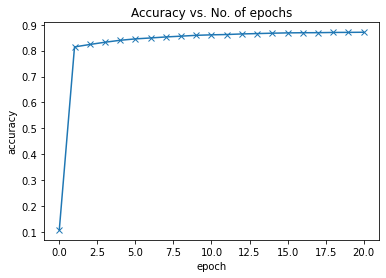

In [49]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

* It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

* The more likely reason that the model just isn't powerful enough. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a linear function of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.

# **Testing with individual images**

In [50]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


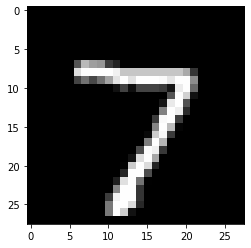

In [51]:
# display the image
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [52]:
# Predict the image
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Label: 7 , Predicted: 7


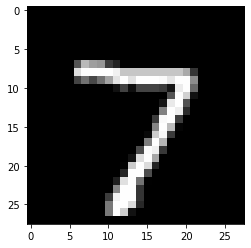

In [53]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


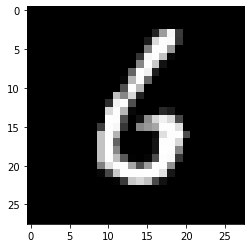

In [55]:
img, label = test_dataset[50]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


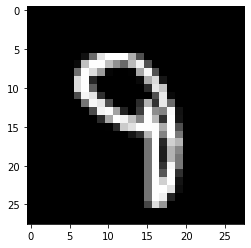

In [56]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


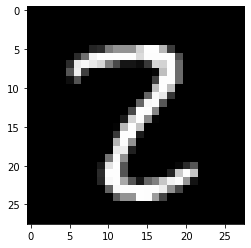

In [57]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [58]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8759765625, 'val_loss': 0.5024033188819885}

# **Saving and Loading the model**

In [59]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [60]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0354,  0.0074, -0.0227,  ..., -0.0108,  0.0329, -0.0236],
                      [ 0.0156, -0.0084,  0.0025,  ..., -0.0304, -0.0204,  0.0173],
                      [-0.0189,  0.0075, -0.0221,  ...,  0.0152, -0.0076, -0.0230],
                      ...,
                      [ 0.0326, -0.0054, -0.0093,  ...,  0.0179, -0.0111,  0.0330],
                      [-0.0137, -0.0103,  0.0105,  ..., -0.0088,  0.0222,  0.0255],
                      [ 0.0305,  0.0250,  0.0266,  ..., -0.0082,  0.0067, -0.0091]])),
             ('linear.bias',
              tensor([-0.0412,  0.1467, -0.0182, -0.0419,  0.0757,  0.1226, -0.0292,  0.0831,
                      -0.1265, -0.0274]))])

# **Load the Model**

In [61]:
model2 = MnistModel()

In [62]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-9.4020e-03,  2.2490e-02, -1.4916e-02,  ..., -6.2948e-03,
                       -3.4861e-02, -9.1629e-03],
                      [ 1.0052e-02, -2.5706e-02,  4.4190e-04,  ..., -7.2437e-05,
                        3.2715e-02, -1.1000e-02],
                      [ 1.8252e-02, -2.0146e-02, -1.7429e-02,  ...,  1.0992e-02,
                        1.0175e-02, -5.2203e-03],
                      ...,
                      [-1.5179e-02,  2.9327e-02, -1.0030e-02,  ..., -1.7854e-02,
                        3.2854e-02, -3.7468e-03],
                      [ 7.6066e-03,  8.7039e-04,  3.4161e-02,  ...,  2.4461e-02,
                       -3.0178e-02, -1.0883e-02],
                      [-1.3326e-02,  1.8726e-02,  2.1616e-02,  ..., -2.1839e-02,
                       -1.8549e-02,  2.6351e-02]])),
             ('linear.bias',
              tensor([-0.0344, -0.0145,  0.0346,  0.0009, -0.0340, -0.0036, -0.0334,  0.0336,
                       0.0337,

In [63]:
evaluate(model2, test_loader)

{'val_acc': 0.12021484225988388, 'val_loss': 2.2975497245788574}

In [64]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0354,  0.0074, -0.0227,  ..., -0.0108,  0.0329, -0.0236],
                      [ 0.0156, -0.0084,  0.0025,  ..., -0.0304, -0.0204,  0.0173],
                      [-0.0189,  0.0075, -0.0221,  ...,  0.0152, -0.0076, -0.0230],
                      ...,
                      [ 0.0326, -0.0054, -0.0093,  ...,  0.0179, -0.0111,  0.0330],
                      [-0.0137, -0.0103,  0.0105,  ..., -0.0088,  0.0222,  0.0255],
                      [ 0.0305,  0.0250,  0.0266,  ..., -0.0082,  0.0067, -0.0091]])),
             ('linear.bias',
              tensor([-0.0412,  0.1467, -0.0182, -0.0419,  0.0757,  0.1226, -0.0292,  0.0831,
                      -0.1265, -0.0274]))])

**Let's verify that this model has the same loss and accuracy on the test set as before.**

In [65]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.8759765625, 'val_loss': 0.5024033188819885}